In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/carvana-image-masking-challenge" directory.

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'metadata.csv', 'train_masks.csv', 'sample_submission.csv', 'train_masks']


In [2]:
os.listdir()

['__notebook_source__.ipynb', '.ipynb_checkpoints']

In [3]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

metadata.csv
sample_submission.csv
test
train
train_masks
train_masks.csv



In [4]:
# Load all the necessary libraries
import numpy as np 
import gzip
import os 
from os.path import basename
import glob
import time 
import cv2
import pandas as pd 
import random
from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.misc import imresize
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from keras.models import Model 
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.optimizers import Adam, SGD 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras import backend as K

K.set_image_dim_ordering('th') # Theano dimension ordering in this code


Using TensorFlow backend.


In [5]:
INPUT_PATH='../input/'
print(os.getcwd())
dims=[128,128]
img_rows=dims[0]
img_cols=dims[1]
train=sorted(glob.glob(INPUT_PATH+'train/*.jpg'))
masks=sorted(glob.glob(INPUT_PATH+'train_masks/*.gif'))
test=sorted(glob.glob(INPUT_PATH+'test/*.jpg'))
print('Number of training images: ', len(train), 'Number of corresponding masks: ', len(masks), 'Number of test images: ', len(test))

meta=pd.read_csv(INPUT_PATH+'metadata.csv')
mask_df=pd.read_csv(INPUT_PATH+'train_masks.csv')
ids_train=mask_df['img'].map(lambda s: s.split('_')[0]).unique()
print('Length of ids_train ', len(ids_train))

/kaggle/working
Number of training images:  5088 Number of corresponding masks:  5088 Number of test images:  100064
Length of ids_train  318


In [6]:
mask_df.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


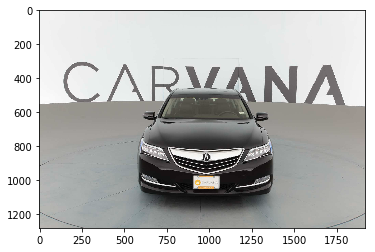

In [7]:
image = cv2.imread(INPUT_PATH+"train/00087a6bd4dc_01.jpg")
plt.imshow(image)
plt.show()

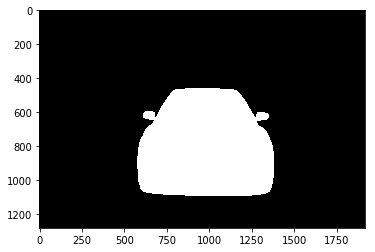

In [8]:
img = Image.open(INPUT_PATH+'train_masks/00087a6bd4dc_01_mask.gif').convert('RGB')
plt.imshow(img)
plt.show()

In [9]:
img2mask=np.array(img)
print(img2mask.shape)
print(image.shape)

(1280, 1918, 3)
(1280, 1918, 3)


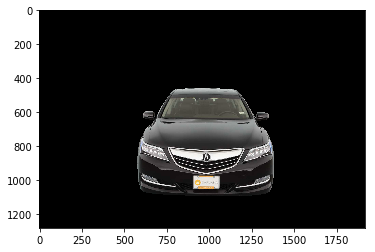

In [10]:
masked_img=cv2.bitwise_and(image,img2mask)
plt.imshow(masked_img)

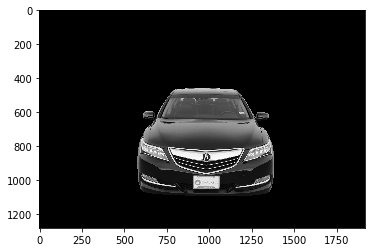

In [11]:
masked_gray=cv2.cvtColor(masked_img,cv2.COLOR_BGR2GRAY)
plt.imshow(masked_gray, cmap='gray')

In [16]:
masked_gray.shape

(1280, 1918)

In [17]:
#cv2.imshow('masked_gray',masked_gray)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [18]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection=K.sum(y_true_f * y_pred_f)
    return(2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_mp(y_true, y_pred):
    y_true_f=y_true.flatten()
    y_pred_f=y_pred.flatten()
    intersection = np.sum(y_true_f*y_pred_f)
    return(2. * intersection + smooth)/(np.sum(y_pred_f) + mp.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [19]:
def get_layer(inputs, pixel, pool=True):
    conv = Conv2D(pixel, (3, 3), padding="same", activation='relu')(inputs)
    conv = Conv2D(pixel, (3 ,3), padding="same", activation='relu')(conv)
    if pool:
        pool = MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        pool = None
    return conv, pool

In [20]:
def get_unet():
    inputs = Input((3,img_rows, img_cols))
    conv1 = Conv2D(32, (3, 3), padding="same", activation='relu')(inputs)    
    conv1 = Conv2D(32, (3, 3), padding="same", activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), padding="same", activation='relu')(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation='relu')(conv2)    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding="same", activation='relu')(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation='relu')(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding="same", activation='relu')(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation='relu')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    #      Concatenate(axis=3)([residual, upconv])
    conv6 = Conv2D(256, (3, 3), padding="same", activation='relu')(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation='relu')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(128, (3, 3), padding="same", activation='relu')(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation='relu')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64, (3, 3), padding="same", activation='relu')(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation='relu')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, (3, 3), padding="same", activation='relu')(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation='relu')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)   #9

    model = Model(inputs=inputs, outputs=conv10)
    #      `Model(inputs=/input_19, outputs=sigmoid.0)`

    #model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])  #LUNA16
    model.compile(optimizer=Adam(5e-4), loss='binary_crossentropy', metrics=[dice_coef]) #ecobill

    return model

In [21]:
#split the train se into train and validation
train_images, validation_images = train_test_split(train, train_size=0.8, test_size=0.2)
print('Split into training set with ', len(train_images), ' images anf validation set with ', len(validation_images), ' images')

Split into training set with  4070  images anf validation set with  1018  images


In [24]:
#utility function to convert greyscale inages to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img

#generator that we will use to read data from the directory
def data_gen_small(data_dir, masks, images, batch_size, dims):
    """ 
    data_dir: where the actual images are kept
    mask_dir: where the actual masks are kept 
    images: the filenames of the images wi want to generate batches from 
    batch_size: self explanatory
    dims: the dimensions in which wi want to rescale our images
    
    Image.resize(size, resample=0)
    
    Returns a resized copy of this image.
    Parameters: 
    
    size - The requested size in pixels, as a 2-tuple: (width, height).
    resample - An optional resampling filter. This can be one of PIL.Image.NEAREST,
    PIL.Image.BOX, PIL.Image.HAMMING, PIL.Image.BICUBIC or PIL.Image.LANCZOS
    If omitted, or if the image has mode "1" or "P", it is set PIL.Image.NEAREST
    """
    while True:
        if batch_size==1:
            ix=np.array([0])
        else:
            ix=np.random.choice(np.arange(len(images)), batch_size)
        
        imgs = []
        labels = []
        for i in ix:
            # images
            #print(images[i])
            if batch_size==1:
                original_img = cv2.imread(images)
            else:
                original_img = cv2.imread(images[i])
            
            resized_img = imresize(original_img, dims + [3]) #this looks like TensorFlow ordering
            array_img = resized_img/255
            array_img = array_img.swapaxes(0, 2)
            imgs.append(array_img)
            #imgs is a numpy array with dim: (batch size X 128 X 128 3)
            #print('shape of imgs ', array_img.shape)
            # masks
            try:
                mask_filename = basename(images[i])
                no_extension = os.path.splitext(mask_filename)[0]
                correct_mask = INPUT_PATH + 'train_masks/' + no_extension + '_mask.gif'
                original_mask = Image.open(correct_mask).convert('L')
                data = np.asarray(original_mask, dtype="int32")
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = resized_mask / 255
                labels.append(array_mask)
            except Exception as e:
                labels=None
            
        imgs = np.array(imgs)
        labels = np.array(labels)
        try:
            relabel = labels.reshape(-1, dims[0], dims[1], 1)
            relabel = relabel.swapaxes(1, 3)
        except Exception as e:
            relabel=labels
        yield imgs, relabel

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Size of batch:  2
shape of img  (2, 3, 128, 128) number dimensions:  3
shape of msk  (2, 1, 128, 128) number dimensions:  3


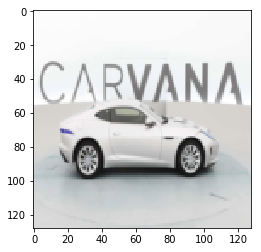

resized up:  (1280, 1918, 3)
resized swapaxes:  (1918, 1280, 3)
resized swapaxes shape[-1]:  3


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


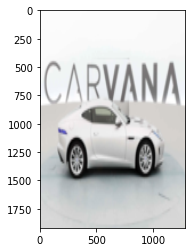

(2, 128, 128, 1)


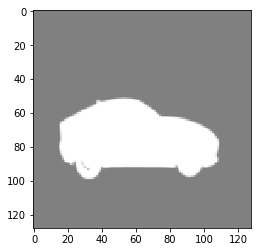

In [25]:
train_gen = data_gen_small(INPUT_PATH + 'train/', masks, train_images, 2, dims) 
img, msk = next(train_gen)
print('Size of batch: ', len(img))
print('shape of img ', img.shape, 'number dimensions: ', img[0].ndim)
print('shape of msk ', msk.shape, 'number dimensions: ', msk[0].ndim)
newshape = img[0].swapaxes(0,2)
plt.imshow(newshape)
plt.show()

#try resize up 

resized_img = imresize(img[0], [1280, 1918]+[3])
print('resized up: ', resized_img.shape)
newshape = resized_img.swapaxes(0,1)
print('resized swapaxes: ', newshape.shape)
print('resized swapaxes shape[-1]: ', newshape.shape[-1])

plt.imshow(newshape)
plt.show()

newshape = msk.swapaxes(1,3)
print(newshape.shape)
plt.imshow(grey2rgb(newshape[0]), alpha=0.5)
plt.show()

In [26]:
# create an instance of a validation generator:
validation_gen = data_gen_small(INPUT_PATH + 'train/', masks, validation_images, 4, dims) 

In [27]:
# define and compile the model
model = get_unet()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 128, 128)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 128, 128) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 128, 128) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 64, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [28]:
# fit the model and check dice_coef on validation data as end of each epoch
model.fit_generator(train_gen, steps_per_epoch=50, epochs=35, validation_data=validation_gen, validation_steps=50)

Epoch 1/35


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


50/50 [==============================] - 26s 517ms/step - loss: 0.4069 - dice_coef: 0.3907 - val_loss: 0.2483 - val_dice_coef: 0.6426
Epoch 2/35
50/50 [==============================] - 18s 363ms/step - loss: 0.1587 - dice_coef: 0.7501 - val_loss: 0.1299 - val_dice_coef: 0.8119
Epoch 3/35
50/50 [==============================] - 22s 449ms/step - loss: 0.1059 - dice_coef: 0.8424 - val_loss: 0.1138 - val_dice_coef: 0.8558
Epoch 4/35
50/50 [==============================] - 21s 419ms/step - loss: 0.1074 - dice_coef: 0.8437 - val_loss: 0.0884 - val_dice_coef: 0.8827
Epoch 5/35
50/50 [==============================] - 21s 412ms/step - loss: 0.0990 - dice_coef: 0.8637 - val_loss: 0.0776 - val_dice_coef: 0.8824
Epoch 6/35
50/50 [==============================] - 21s 421ms/step - loss: 0.0860 - dice_coef: 0.8781 - val_loss: 0.0796 - val_dice_coef: 0.9010
Epoch 7/35
50/50 [==============================] - 21s 411ms/step - loss: 0.0655 - dice_coef: 0.9073 - val_loss: 0.0628 - val_dice_coef: 0.9

In [29]:
img, msk = next(validation_gen)
print(img.shape)
predicted_mask = model.predict(img)
predicted_mask.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(4, 3, 128, 128)


(4, 1, 128, 128)

newshape shape  (4, 128, 128, 1)
grey shape  (128, 128, 3)


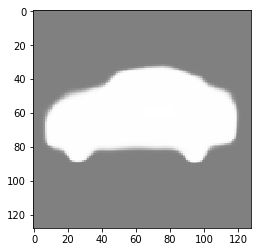

In [30]:
newshape = predicted_mask.swapaxes(1,3)
print('newshape shape ', newshape.shape)
grey = grey2rgb(newshape[3])
print('grey shape ', grey.shape)
plt.imshow(grey, alpha = 0.5)
plt.show()

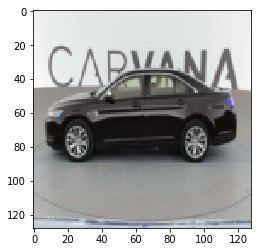

In [31]:
newshape = img[3].swapaxes(0,2)
plt.imshow(newshape)
plt.show()

**Prediction on the unseen data set**

In [32]:
validation_test = data_gen_small(INPUT_PATH + 'test/', masks, test, 4, dims) 
img_tst, msk_tst = next(validation_test)
print(img_tst.shape)
predicted_mask_tst = model.predict(img_tst)
predicted_mask_tst.shape

(4, 3, 128, 128)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(4, 1, 128, 128)

newshape shape  (4, 128, 128, 1)
grey shape  (128, 128, 3)


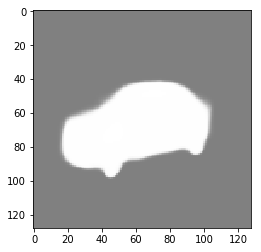

In [33]:
newshape_tst = predicted_mask_tst.swapaxes(1,3)
print('newshape shape ', newshape_tst.shape)
grey_tst = grey2rgb(newshape_tst[3])
print('grey shape ', grey_tst.shape)
plt.imshow(grey_tst, alpha = 0.5)
plt.show()

(128, 128, 3)


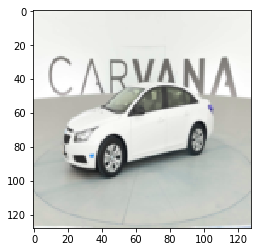

In [34]:
newshape_tst = img_tst[3].swapaxes(0,2)
print(newshape_tst.shape)
plt.imshow(newshape_tst)
plt.show()

newshape shape  (4, 128, 128, 1)
grey shape  (128, 128, 3)


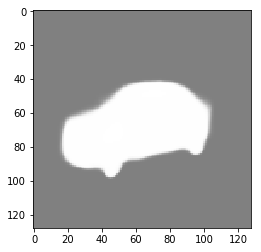

In [35]:
newshape_tst = predicted_mask_tst.swapaxes(1,3)
print('newshape shape ', newshape_tst.shape)
grey_tst = grey2rgb(newshape_tst[3])
print('grey shape ', grey_tst.shape)
plt.imshow(grey_tst, alpha = 0.5)
plt.show()

In [48]:
'''def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs'''
def rle (img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    bytes = np.where(img.flatten()==1)[0]
    runs = []
    prev = -2
    for b in bytes:
        if (b>prev+1): runs.extend((b+1, 0))
        runs[-1] += 1
        prev = b
    
    return ' '.join([str(i) for i in runs])

In [37]:
from tqdm import tqdm_notebook as tqdm

In [64]:
df=pd.DataFrame(columns=['img','rle_mask'])

In [39]:
'''def par_predict(tst_img):
    validation_test = data_gen_small(INPUT_PATH + 'test/', 'masks', tst_img, 1, dims)
    img_tst, msk_tst = next(validation_test)
    predicted_mask_tst = model.predict(img_tst)
    
    newshape_tst = predicted_mask_tst.swapaxes(1,3)
    grey_tst = grey2rgb(newshape_tst[0])
    gray_tst = np.array(grey_tst*255, dtype='uint8')
    gray_tst[gray_tst>128]=1
    gray_tst[gray_tst<=128]=0
    
    mask=rle_encode(gray_tst)
    file=tst_img.split('/')[-1]
    df.loc[len(df)]=[file, mask]
'''

"def par_predict(tst_img):\n    validation_test = data_gen_small(INPUT_PATH + 'test/', 'masks', tst_img, 1, dims)\n    img_tst, msk_tst = next(validation_test)\n    predicted_mask_tst = model.predict(img_tst)\n    \n    newshape_tst = predicted_mask_tst.swapaxes(1,3)\n    grey_tst = grey2rgb(newshape_tst[0])\n    gray_tst = np.array(grey_tst*255, dtype='uint8')\n    gray_tst[gray_tst>128]=1\n    gray_tst[gray_tst<=128]=0\n    \n    mask=rle_encode(gray_tst)\n    file=tst_img.split('/')[-1]\n    df.loc[len(df)]=[file, mask]\n"

In [65]:
def par_predict(img_num):
    validation_test = data_gen_small(INPUT_PATH + 'test/', 'masks', test[img_num], 1, dims)
    img_tst, msk_tst = next(validation_test)
    predicted_mask_tst = model.predict(img_tst)
    
    newshape_tst = predicted_mask_tst.swapaxes(1,3)
    grey_tst = grey2rgb(newshape_tst[0])
    gray_tst = np.array(grey_tst*255, dtype='uint8')
    gray_tst[gray_tst<=128]=0
    gray_tst[gray_tst>128]=1
    
    #mask=rle_encode(gray_tst)
    #print(gray_tst[gray_tst==1])
    mask=rle(gray_tst)
    file=test[img_num].split('/')[-1]
    return [file, mask]


In [66]:
'''for i in tqdm(test, total=len(test)):
    validation_test = data_gen_small(INPUT_PATH + 'test/', masks, i, 1, dims)
    img_tst, msk_tst = next(validation_test)
    predicted_mask_tst = model.predict(img_tst)
    
    newshape_tst = predicted_mask_tst.swapaxes(1,3)
    grey_tst = grey2rgb(newshape_tst[0])
    gray_tst = np.array(grey_tst*255, dtype='uint8')
    gray_tst[gray_tst>128]=1
    gray_tst[gray_tst<=128]=0
    
    mask=rle_encode(gray_tst)
    file=i.split('/')[-1]
    df.loc[len(df)]=[file, mask]'''

#Parallel(n_jobs=num_cores)(par_predict(i) for i in tqdm(test, total=len(test)))
#b=0
ln=len(test)
#ln=int(ln/4)
#ln=10 #testing the rle file
st=len(df)
print('Number images going to be processed: {}'.format(ln))
#pbar = tqdm(total = ln+1)
for i in tqdm(range(st,ln)):
    df.loc[len(df)]=par_predict(i)
    if i % 1000 == 0:
        df.to_csv('csv_to_submit.csv', index = False)
#pbar.close()
df.to_csv('csv_to_submit.csv', index = False)


Number images going to be processed: 10


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [ ]:
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a random sample dataframe
#df = pd.DataFrame(np.random.randn(50, 4), columns=list('ABCD'))

# create a link to download the dataframe
create_download_link(df)

# ↓ ↓ ↓  Yay, download link! ↓ ↓ ↓ 